['so_subsets/1C-CS-81E41S160E64S.GPM.GMI.XCAL2016-C.20240901-S071747-E073028.059684.V07B.HDF5', 'so_subsets/2A-CS-81E41S160E64S.GPM.DPR.V9-20240130.20240901-S071900-E073029.059684.V07C.HDF5', 'so_subsets/2A-CS-81E41S160E64S.GPM.GMI.GPROF2021v1.20240901-S071747-E073028.059684.V07C.HDF5', 'so_subsets/2B-CS-81E41S160E64S.GPM.DPRGMI.CORRA2022.20240901-S071900-E073029.059684.V07C.HDF5']


/Users/mgrecu/miniforge3/lib/python3.10/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  get_neighbour_info(source_geo_def,


328 328
(16072,)


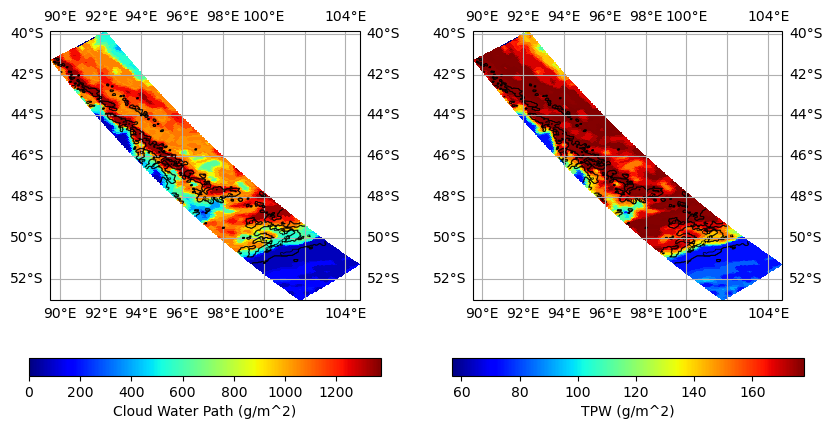

In [39]:
f1C11='so_subsets/1C-CS-81E41S160E64S.GPM.GMI.XCAL2016-C.20240901-S054432-E055430.059683.V07B.HDF5'
f2ADPR='so_subsets/2A-CS-81E41S160E64S.GPM.DPR.V9-20240130.20240901-S054546-E055514.059683.V07C.HDF5'
f2BCMB='so_subsets/2B-CS-81E41S160E64S.GPM.DPRGMI.CORRA2022.20240901-S054546-E055514.059683.V07C.HDF5'
import glob
fnames=sorted(glob.glob('so_subsets/*.059684*.HDF5'))
print(fnames)
f1C11=fnames[0]
f2ADPR=fnames[1]
fgprof=fnames[2]
f2BCMB=fnames[3]
import io_subs
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyresample import image, geometry
qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,oe_wvp,oe_lwp,oe_iwp,oesfc_precip,stormTop,nearSfcPrecip,zeroDegAltitude,surfaceType=io_subs.readCMB(f2BCMB)
pType=(pType/1e7).astype(int)
lat_s1,lon_s1,tb_s1=io_subs.read1CGMI(f1C11)

input_def = geometry.SwathDefinition(lons=lon_s1[:,:], lats=lat_s1[:,:])
output_def = geometry.SwathDefinition(lons=lon, lats=lat)
# Resample the tb_s1 data to the CMB grid using gaussian resampling
wf = lambda r: 1 - r/20000.0
tb_s1_resampled = resample_custom(input_def, tb_s1[:,:,:], output_def, radius_of_influence=30000, neighbours=10, 
weight_funcs=[wf for k in range(9)], fill_value=None)

hFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,7]
a=[2,4,6,8]
import pickle

#pickle.dump(knn,open('knncldwp_4.pklz','wb'))
#pickle.dump(knn_tpw,open('knntpw_4.pklz','wb'))
knn=pickle.load(open('knncldwp_4.pklz','rb'))
knn_tpw=pickle.load(open('knntpw_4.pklz','rb'))
ndpr=qv.shape[0]

x_input=tb_s1_resampled[:ndpr//3,:,a].reshape(-1,4)

import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
cldwp=knn.predict(x_input)
tpw=knn_tpw.predict(x_input)
print(x_input.shape[0]//49,ndpr//3)
print(cldwp.shape)
cldwp_2d=cldwp.reshape(ndpr//3,49)
tpw_2d=tpw.reshape(ndpr//3,49)
ax=plt.subplot(121,projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.right_labels=False
ax.top_labels=False
c=plt.pcolormesh(lon[:ndpr//3],lat[:ndpr//3],cldwp_2d*250,cmap='jet',transform=ccrs.PlateCarree())
plt.contour(lon[:ndpr//3],lat[:ndpr//3],pType[:ndpr//3,:],levels=[0.1,0.5,1],colors='black',transform=ccrs.PlateCarree(),linewidths=0.5)
plt.colorbar(c,orientation='horizontal',label='Cloud Water Path (g/m^2)')
#plt.figure()
ax2=plt.subplot(122,projection=ccrs.PlateCarree())
c2=plt.pcolormesh(lon[:ndpr//3],lat[:ndpr//3],tpw_2d,cmap='jet',transform=ccrs.PlateCarree())
plt.contour(lon[:ndpr//3],lat[:ndpr//3],pType[:ndpr//3,:],levels=[0.1,0.5,1],colors='black',transform=ccrs.PlateCarree(),linewidths=0.5)
gl2=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl2.xlabels_top = False
gl2.ylabels_right = False
#gl2.ylabel_artist.set_fontsize(8)
#ax2.draw_meridians(np.arange(-180,180,5),labels=[0,0,0,1])
#gl2.xlabels_top = False
plt.colorbar(c2,orientation='horizontal',label='TPW (g/m^2)')
plt.savefig('retrieved_cldwp_tpw_59684.png',dpi=300)
